In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_base_dir = '../../../../datasets/Movielens/'
data_dir = data_base_dir + 'serendipity-sac2018/'
data_dir2 = data_base_dir + 'ml-20m/'
output_dir = data_dir + 'output/'

# genome_scores = data_dir + 'genome_scores.csv'
genome_scores = data_dir + 'tag_genome.csv'
# genome_tags = data_dir + 'genome-tags.csv'
movies = data_dir + 'movies.csv'
# ratings = data_dir + 'ratings.csv'
ratings = data_dir + 'training.csv'
# tags = data_dir + 'tags.csv'
answers = data_dir + 'answers.csv'
genre_binary_terms = output_dir + 'movie_genre_binary_term_vector_df_bz2'
movies_lemmatized = output_dir + 'movies_lemmatized_genome_vector_df_bz2'

answers_df = pd.read_csv(answers)

# data loading and preprocessing
genome_scores_df = pd.read_csv(genome_scores).pivot(index='movieId', columns='tagId', values='relevance')
movies_with_genome = genome_scores_df.index.values
movies_with_genome

movies_df = pd.read_csv(movies)
movies_df = movies_df[movies_df['genres'] != '(no genres listed)']
movies_df = movies_df[movies_df['movieId'].isin(movies_with_genome)]

all_movie_ids = movies_df['movieId'].unique()

ratings_df = pd.read_csv(ratings)
ratings_df = ratings_df[ratings_df['movieId'].isin(all_movie_ids)]
ratings_df = ratings_df.loc[:, ['userId', 'movieId', 'rating']]

all_user_ids = ratings_df['userId'].unique()

ratings_df

,userId,movieId,rating
72,142882,257,0.5
98,142882,428,2.5
99,142882,381,1.0
102,142882,765,0.5
104,142882,374,0.5
105,142882,481,1.5
111,142882,837,2.0
134,142882,60,1.5
145,142912,589,4.0
179,142882,105,2.5


In [6]:
# TODO also filter users only inside recommendations or answers dataframe
count_df = answers_df.groupby('userId').count()
count_df[count_df['movieId'] == 5]
all_answers_user_ids = count_df[count_df['movieId'] == 5].index.values

In [14]:
from sklearn.metrics import pairwise_distances, mean_absolute_error, mean_squared_error

class ContentBased_Recommender:
    def __init__(self, term_vector_df, ratings_df, K=5, metric='cosine'):
        self.term_vector_df = term_vector_df
        self.K = K
        self.ratings_df = ratings_df

        # preprocessing and other calculations
        self.term_vector_df.fillna(0, inplace=True)
        self.movie_movie_distances = pd.DataFrame(
            pairwise_distances(self.term_vector_df, metric=metric), index=self.term_vector_df.index,
            columns=self.term_vector_df.index)

    def get_mae_mse(self, user_id, candidate_movie_id, user_movies, K=None, weighted=True):
        # movies watched by user
        #         if user_movies is None:
        #             user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

        # hide candidate movie from the user
        user_movies = np.setdiff1d(user_movies, candidate_movie_id)

        # load user rating for watched movies other than the candidate movie
        # user_ratings =
        users_all_ratings_df = ratings_df[ratings_df['userId'] == user_id]
        users_all_ratings_df = users_all_ratings_df[
            users_all_ratings_df['movieId'].isin(user_movies)]

        # load similarities to the candidate movie
        users_all_ratings_df['sim_candidate_movie'] = self.movie_movie_distances.loc[
            candidate_movie_id, users_all_ratings_df['movieId']].values[0]

        mae, mse = self.predict_ratings_and_get_mae_mse(user_id, candidate_movie_id, 
                                                        users_all_ratings_df, K)

        return mae, mse

    def predict_ratings_and_get_mae_mse(self, user_id, candidate_movie_id, users_all_ratings_df, 
                                        K=5, weighted=True):
        user_ratings = users_all_ratings_df['rating'].values[:K]
        similarities = users_all_ratings_df['sim_candidate_movie'].values[:K]

        predicted_rating = 0
        if weighted:
            # weighted average
            predicted_rating = np.sum(user_ratings * similarities) / np.sum(similarities)
        else:
            # non-weighted average
            predicted_rating = np.sum(user_ratings) / len(user_ratings)

        actual_rating = self.ratings_df[(self.ratings_df['userId'] == user_id) & (self.ratings_df['movieId'] == candidate_movie_id)]['rating'].values[0]

        if np.isnan(predicted_rating):
#             predicted_rating = 0
            predicted_rating = actual_rating
            
        mae = mean_absolute_error([actual_rating], [predicted_rating])
        mse = mean_squared_error([actual_rating], [predicted_rating])

        return mae, mse

    def get_average_mae_mse(self, user_id, user_movies, K=None, weighted=True):
        # movies watched by user
        #         if user_movies is None:
        #             user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

        mae_list = list()
        mse_list = list()

        for candidate_movie_id in user_movies:
            mae, mse = self.get_mae_mse(user_id, candidate_movie_id, user_movies, K, weighted)

            mae_list.append(mae)
            mse_list.append(mse)

        return np.array(mae_list).mean(), np.array(mse_list).mean()

In [8]:
l1 ='movies_lemmatized_threshold_'
l2 = '_float_movie_genomes_bz2'

# threshold_0.2_float_movie_genomes_bz2
l3 = 'threshold_'
l4 = '_float_movie_genomes_bz2'
thresholds = [0.25, 0.4, 0.7]

lemmatized_labels = [(l1 + str(x) + l2) for x in thresholds]
lemmatized_labels

full_labels = [(l3 + str(x) + l4) for x in thresholds]
full_labels

['threshold_0.25_float_movie_genomes_bz2',
 'threshold_0.4_float_movie_genomes_bz2',
 'threshold_0.7_float_movie_genomes_bz2']

In [9]:
# loading all required data
user_full_genome_terms_df = pd.read_pickle(output_dir + 'user_full_genome_terms_df_bz2', compression='bz2')
user_full_genome_terms_gzip_df = pd.read_pickle(output_dir + 'user_full_genome_terms_df_gzip', compression='bz2')

lemmatized_thresholded_dfs = list()
full_thresholded_dfs = list()

for i, t in enumerate(thresholds):
    lemmatized_thresholded_dfs.append(pd.read_pickle(output_dir + lemmatized_labels[i], compression='bz2'))
    full_thresholded_dfs.append(pd.read_pickle(output_dir + lemmatized_labels[i], compression='bz2'))

In [10]:
# load term vectors
genre_binary_terms_df = pd.read_pickle(genre_binary_terms, compression='bz2')
movies_lemmatized_df = pd.read_pickle(movies_lemmatized, compression='bz2')

In [ ]:
import matplotlib.pyplot as plt
from time import time
import warnings

warnings.filterwarnings('ignore')

def run(index, K):
    labels = ['genre_binary', 'genome_full', 'genome_lemmatized']
    all_movie_ids = genre_binary_terms_df.index.values

#     for index, K in enumerate(K_ranges):
    genre_recommender = ContentBased_Recommender(genre_binary_terms_df, ratings_df, K, 'jaccard')
    genome_full_recommender = ContentBased_Recommender(genome_scores_df, ratings_df, K, 'cosine')
    genome_lemmatized_recommender = ContentBased_Recommender(movies_lemmatized_df, ratings_df, K, 'cosine')

    lemmatized_recommenders = list()
    full_recommenders = list()
    for i, t in enumerate(thresholds):
        full_recommenders.append(ContentBased_Recommender(full_thresholded_dfs[i], ratings_df, K))
        lemmatized_recommenders.append(ContentBased_Recommender(lemmatized_thresholded_dfs[i], ratings_df, K))

    # mae lists
    genre_mae_list = list()
    genome_full_mae_list = list()
    genome_lemmatized_mae_list = list()

    lemmatized_mae_list = list()
    full_mae_list = list()

    # mse lists
    genre_mse_list = list()
    genome_full_mse_list = list()
    genome_lemmatized_mse_list = list()

    lemmatized_mse_list = list()
    full_mse_list = list()

    for user_id in all_answers_user_ids[:]:
        start_time = time()
        print('user_id', user_id)

        # movies watched by user
        user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

        mae, mse = genre_recommender.get_average_mae_mse(user_id, user_movies, K=None, weighted=True)
        genre_mae_list.append(mae)
        genre_mse_list.append(mse)

        mae, mse = genome_full_recommender.get_average_mae_mse(user_id, user_movies, K=None, weighted=True)
        genome_full_mae_list.append(mae)
        genome_full_mse_list.append(mse)

        mae, mse = genome_lemmatized_recommender.get_average_mae_mse(user_id, user_movies, K=None, weighted=True)
        genome_lemmatized_mae_list.append(mae)
        genome_lemmatized_mse_list.append(mse)

        for i, t in enumerate(thresholds):
            mae, mse = full_recommenders[i].get_average_mae_mse(user_id, user_movies, K=None, weighted=True)
            full_mae_list.append(mae)
            full_mse_list.append(mse)

            mae, mse = lemmatized_recommenders[i].get_average_mae_mse(user_id, user_movies, K=None, weighted=True)
            lemmatized_mae_list.append(mae)
            lemmatized_mse_list.append(mse)

        finish_time = time() - start_time
        print("Total time taken for this user: %f seconds" % finish_time)

    mae_df = pd.DataFrame()
    mae_df['genre_MAE'] = genre_mae_list
    mae_df['genome_full_MAE'] = genome_full_mae_list
    mae_df['genome_lemmatized_MAE'] = genome_lemmatized_mae_list

    mse_df = pd.DataFrame()
    mse_df['genre_MSE'] = genre_mse_list
    mse_df['genome_full_MSE'] = genome_full_mse_list
    mse_df['genome_lemmatized_MSE'] = genome_lemmatized_mse_list

    for i, t in enumerate(thresholds):
        mae_df[full_labels[i] + '_MAE'] = full_mae_list[i]
        mse_df[full_labels[i] + '_MSE'] = full_mse_list[i]

        mae_df[lemmatized_labels[i] + '_MAE'] = lemmatized_mae_list[i]
        mse_df[lemmatized_labels[i] + '_MSE'] = lemmatized_mse_list[i]

    print("")
    mae_df.mean().plot(kind='barh', title='K=' + str(K) + ', avg MAE across all users, for all movies')
    plt.show()
    mse_df.mean().plot(kind='barh', title='K=' + str(K) + ', avg MSE across all users, for all movies')
    plt.show()
    
import multiprocessing as mp
import matplotlib.pyplot as plt

# K_ranges = [5, 10, 15, 20, 30, 40, 50]
K_ranges = [5, 10, 15]

p_list = list()
for index, K in enumerate(K_ranges):
    p = mp.Process(target=run, args=(index, K,))
    p_list.append(p)
    p.start()

for p in p_list:
    # wait until all processes are finished
    p.join()

print("main process")

user_id 100200
user_id 100200
user_id 100200
Total time taken for this user: 20.374994 seconds
user_id 100269
Total time taken for this user: 20.341743 seconds
user_id 100269
Total time taken for this user: 20.507096 seconds
user_id 100269
Total time taken for this user: 40.572005 seconds
user_id 100521
Total time taken for this user: 40.895291 seconds
user_id 100521
Total time taken for this user: 40.930555 seconds
user_id 100521
Total time taken for this user: 25.609247 seconds
user_id 100972
Total time taken for this user: 25.500636 seconds
user_id 100972
Total time taken for this user: 25.570994 seconds
user_id 100972
Total time taken for this user: 23.254683 seconds
user_id 100998
Total time taken for this user: 23.272807 seconds
user_id 100998
Total time taken for this user: 23.322692 seconds
user_id 100998
Total time taken for this user: 5.786702 seconds
user_id 101049
Total time taken for this user: 5.803858 seconds
user_id 101049
Total time taken for this user: 5.766321 second

Total time taken for this user: 22.058703 seconds
user_id 110246
Total time taken for this user: 22.000033 seconds
user_id 110246
Total time taken for this user: 22.220606 seconds
user_id 110246
Total time taken for this user: 12.895879 seconds
user_id 110296
Total time taken for this user: 12.869947 seconds
user_id 110296
Total time taken for this user: 12.910633 seconds
user_id 110296
Total time taken for this user: 2.682408 seconds
user_id 110343
Total time taken for this user: 2.652580 seconds
user_id 110343
Total time taken for this user: 2.669862 seconds
user_id 110343
Total time taken for this user: 15.697697 seconds
user_id 110386
Total time taken for this user: 15.895921 seconds
user_id 110386
Total time taken for this user: 15.880864 seconds
user_id 110386
Total time taken for this user: 37.197880 seconds
user_id 110525
Total time taken for this user: 37.222374 seconds
user_id 110525
Total time taken for this user: 37.173628 seconds
user_id 110525
Total time taken for this us

## Old code - single core processing

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


user_id 100972


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


Total time taken for this user: 139.879277 seconds
user_id 100998
Total time taken for this user: 34.173051 seconds


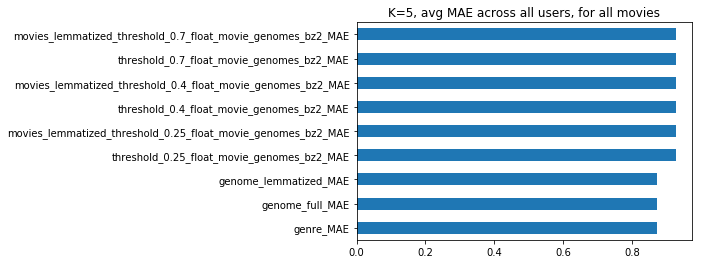

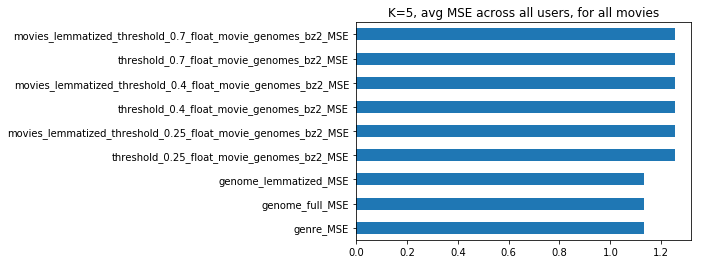

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


user_id 100972


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [152]:
import matplotlib.pyplot as plt
from time import time

labels = ['genre_binary', 'genome_full', 'genome_lemmatized']
all_movie_ids = genre_binary_terms_df.index.values

K_ranges = [5, 10, 15, 20, 30, 40, 50]

for index, K in enumerate(K_ranges):
    genre_recommender = ContentBased_Recommender(genre_binary_terms_df, ratings_df, K, 'jaccard')
    genome_full_recommender = ContentBased_Recommender(genome_scores_df, ratings_df, K, 'cosine')
    genome_lemmatized_recommender = ContentBased_Recommender(movies_lemmatized_df, ratings_df, K, 'cosine')
    
    lemmatized_recommenders = list()
    full_recommenders = list()
    for i, t in enumerate(thresholds):
        full_recommenders.append(ContentBased_Recommender(full_thresholded_dfs[i], ratings_df, K))
        lemmatized_recommenders.append(ContentBased_Recommender(lemmatized_thresholded_dfs[i], ratings_df, K))
        
    # mae lists
    genre_mae_list = list()
    genome_full_mae_list = list()
    genome_lemmatized_mae_list = list()
    
    lemmatized_mae_list = list()
    full_mae_list = list()
    
    # mse lists
    genre_mse_list = list()
    genome_full_mse_list = list()
    genome_lemmatized_mse_list = list()
    
    lemmatized_mse_list = list()
    full_mse_list = list()

    for user_id in all_answers_user_ids[3:5]:
        start_time = time()
        print('user_id', user_id)
        
        # movies watched by user
        user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

        mae, mse = genre_recommender.get_average_mae_mse(user_id, user_movies, K=None, weighted=True)
        genre_mae_list.append(mae)
        genre_mse_list.append(mse)
        
        mae, mse = genome_full_recommender.get_average_mae_mse(user_id, user_movies, K=None, weighted=True)
        genome_full_mae_list.append(mae)
        genome_full_mse_list.append(mse)
        
        mae, mse = genome_lemmatized_recommender.get_average_mae_mse(user_id, user_movies, K=None, weighted=True)
        genome_lemmatized_mae_list.append(mae)
        genome_lemmatized_mse_list.append(mse)
        
        for i, t in enumerate(thresholds):
            mae, mse = full_recommenders[i].get_average_mae_mse(user_id, user_movies, K=None, weighted=True)
            full_mae_list.append(mae)
            full_mse_list.append(mse)
            
            mae, mse = lemmatized_recommenders[i].get_average_mae_mse(user_id, user_movies, K=None, weighted=True)
            lemmatized_mae_list.append(mae)
            lemmatized_mse_list.append(mse)
        
        finish_time = time() - start_time
        print("Total time taken for this user: %f seconds" % finish_time)
    
    mae_df = pd.DataFrame()
    mae_df['genre_MAE'] = genre_mae_list
    mae_df['genome_full_MAE'] = genome_full_mae_list
    mae_df['genome_lemmatized_MAE'] = genome_lemmatized_mae_list
    
    mse_df = pd.DataFrame()
    mse_df['genre_MSE'] = genre_mse_list
    mse_df['genome_full_MSE'] = genome_full_mse_list
    mse_df['genome_lemmatized_MSE'] = genome_lemmatized_mse_list
                                 
    for i, t in enumerate(thresholds):
        mae_df[full_labels[i] + '_MAE'] = full_mae_list[i]
        mse_df[full_labels[i] + '_MSE'] = full_mse_list[i]
        
        mae_df[lemmatized_labels[i] + '_MAE'] = lemmatized_mae_list[i]
        mse_df[lemmatized_labels[i] + '_MSE'] = lemmatized_mse_list[i]
        
    mae_df.mean().plot(kind='barh', title='K=' + str(K) + ', avg MAE across all users, for all movies')
    plt.show()
    mse_df.mean().plot(kind='barh', title='K=' + str(K) + ', avg MSE across all users, for all movies')
    plt.show()